In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pymongo import MongoClient
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from packaging.version import Version
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu
%matplotlib inline
%config InlineBackend.figure_format = "retina"


In [173]:
pypi_db = MongoClient(host='127.0.0.1', port=27017)['pypi']
dl_packages = pypi_db['dl_packages']
distribution_metadata = pypi_db['distribution_metadata']
pkg_layers = pd.read_csv("data/package_statistics.csv")
pkg_layers.head()

,package,layer,framework,dependent_number
0,keras-augm-layer,2,tensorflow,0
1,DeBERTa,3,tensorflow,0
2,lfr,3,tensorflow,0
3,parse-tools,2,tensorflow,0
4,pytorch-to-tflite,2,tensorflow,0


In [174]:
def layer_count():
    layer_count = pkg_layers.groupby(['layer', 'framework'])[
        'package'].count().unstack().fillna(0)
    layer_count.loc['sum', :] = pkg_layers[['framework', 'package']
                                        ].drop_duplicates().groupby('framework')['package'].count()
    layer_count = layer_count.astype(int)
    layer_count = layer_count[frameworks]
    return layer_count
layer_count()

framework,tensorflow,pytorch,mxnet,paddlepaddle,mindspore
layer,,,,,
1,3,1,16,2,3
2,2335,2900,62,34,3
3,714,1903,18,6,0
4,89,161,1,0,0
5,11,13,0,0,0
6,1,1,0,0,0
sum,2700,3434,93,37,6


In [92]:
def min_layer(df: pd.DataFrame):
    return df.sort_values('layer').iloc[0]


def get_dependent_distribution(frameworks):
    res = {}
    top10 = pd.DataFrame()
    for f in frameworks:
        df = pkg_layers[pkg_layers.framework == f].groupby(
            'package')[['layer', 'dependent_number']].apply(min_layer)
        df = df[df.layer > 1].sort_values('dependent_number', ascending=False)
        with_dependents = df['dependent_number']
        print(f'The ratio of packages with downstreams in {f} SC: {len(with_dependents)}/{len(df)}={len(with_dependents)/len(df)*100:.1f}%')
        # print(with_dependents.head(10).to_frame().reset_index())
        top10 = pd.concat([top10, with_dependents.head(10).to_frame().reset_index()], axis=1, ignore_index=True)
        res[f] = with_dependents
    top10 = top10.fillna(0)
    return res, top10

dependent_distribution, top10 = get_dependent_distribution(frameworks[:5])
top10


The ratio of packages with downstreams in tensorflow SC: 2697/2697=100.0%
The ratio of packages with downstreams in pytorch SC: 3433/3433=100.0%
The ratio of packages with downstreams in mxnet SC: 77/77=100.0%
The ratio of packages with downstreams in paddlepaddle SC: 35/35=100.0%
The ratio of packages with downstreams in mindspore SC: 3/3=100.0%


,0,1,2,3,4,5,6,7,8,9
0,Keras,90,torchvision,977,tensorly,9,sabhi-utils,4,HEBO-mindspore,0.0
1,tensorflow-addons,55,pytorch-lightning,226,datawig,2,paddle-serving-client,2,READ-mindspore,0.0
2,tensorflow-probability,48,fastai,88,cnocr,2,ddparser,0,tinyms,0.0
3,streamlit,45,torchaudio,80,onnx-mxnet,1,pydp,0,0,0.0
4,tensorflow-text,44,torchtext,79,gluonts,1,paddlepalm,0,0,0.0
5,seqeval,43,torchmetrics,51,turicreate,1,paddletools,0,0,0.0
6,tensorflow-serving-api,18,timm,47,treform,1,paddlevideo,0,0,0.0
7,rasa,18,stanza,46,mxnet-model-server,1,ppcd,0,0,0.0
8,keras-tuner,17,allennlp,45,Codemao,0,ppvideo,0,0,0.0
9,tf-models-official,13,pytorch-ignite,38,mxop,0,pyunit-ner,0,0,0.0


In [8]:
def compare_dependents():
    # https://stackoverflow.com/a/39513799/11332158
    def gini(x):
        mad = np.abs(np.subtract.outer(x, x)).mean()
        rmad = mad/np.mean(x)
        g = 0.5 * rmad
        return g

    tf = dependent_distribution['tensorflow'].values
    tc = dependent_distribution['pytorch'].values
    print(mannwhitneyu(tf, tc))
    print('Cliffs delta effect size:', cliffs_delta(tf, tc))
    print('Gini coefficient:', gini(tf), gini(tc))

compare_dependents()

MannwhitneyuResult(statistic=65736.0, pvalue=0.969210554931732)
Cliffs delta effect size: (0.0015006665397067226, 'negligible')
Gini coefficient: 0.603261785220878 0.7827195727858853


In [9]:
def common_packages(frameworks: list):
    l = len(frameworks)
    res = dict()
    for i in range(l):
        for j in range(i+1, l):
            pkgs1 = set(
                pkg_layers[pkg_layers.framework == frameworks[i]]['package'])
            pkgs2 = set(
                pkg_layers[pkg_layers.framework == frameworks[j]]['package'])
            res[f'{frameworks[i]}-{frameworks[j]}'] = list(
                pkgs1.intersection(pkgs2))

    return res


common_pkgs = common_packages(frameworks)
for k, v in common_pkgs.items():
    print(k, len(v))


tensorflow-pytorch 355
tensorflow-mxnet 13
tensorflow-paddlepaddle 3
tensorflow-mindspore 0
pytorch-mxnet 38
pytorch-paddlepaddle 7
pytorch-mindspore 1
mxnet-paddlepaddle 0
mxnet-mindspore 0
paddlepaddle-mindspore 0


In [93]:
def agg_fn(df):
    return list(df['layer'].values), df['dependent_number'].iloc[0]
def pp_ms_common():
    return pkg_layers[pkg_layers.package.isin(common_pkgs['pytorch-mindspore']) | 
           pkg_layers.package.isin(common_pkgs['pytorch-paddlepaddle']) | 
           pkg_layers.package.isin(common_pkgs['tensorflow-paddlepaddle'])].groupby([
    'framework', 'package']).agg({'layer': set, 'dependent_number': min})

In [11]:
def get_ordered_versions(packages: list):
    result = dict()
    def latest_time(df):
        return df.sort_values('upload_time', ascending=False).iloc[0]
    for p in packages:
        query = {
            "name": p,
        }
        projection = {
            "name": 1,
            "_id": 0,
            "version": 1,
            "upload_time": 1
        }
        res = pd.DataFrame(list(distribution_metadata.find(query, projection=projection)))
        result[p] = list(res.groupby('version')['upload_time'].max().sort_values().index)
    return result


In [124]:
def version_distance1(idx1, idx2):
    l = min(len(idx1), len(idx2))
    return np.mean(idx1[-l: ]) - np.mean(idx2[-l: ])

def version_distance2(idx1, idx2):
    res = 0
    if idx1[-1] == idx2[-1]:
        res = 0
    elif idx1[-1] < idx2[-1]:
        for i in range(len(idx2)):
            if idx2[-1-i] > idx1[-1]:
                res -=1
    else:
        for i in range(len(idx1)):
            if idx1[-1-i] > idx2[-1]:
                res += 1
    return res


def compare_common_package_versions(framework1: str, framework2: str):
    pkgs = common_pkgs[f'{framework1}-{framework2}']
    ordered_versions = get_ordered_versions(common_pkgs[f'{framework1}-{framework2}'])
    print(len(ordered_versions))
    pipeline = [
        {
            "$match": {
                "framework": {
                    "$in": [framework1, framework2]
                },
                "name": "iglovikov-helper-functions"
            }
        }, {
            "$project": {
                "_id": 0,
                "name": 1,
                "version": 1,
                "framework": 1
            }
        }, {
            "$group": {
                "_id": "$framework",
                "versions": {
                    "$addToSet": "$version"
                }
            }
        }
    ]
    same_count = 0
    distance = dict()
    distance_ratio = dict()
    
    for p in pkgs:
        pipeline[0]["$match"]["name"] = p
        ovs = ordered_versions[p]
        res = pd.DataFrame(list(dl_packages.aggregate(pipeline)))
        versions1 = list(res[res['_id']==framework1]['versions'].values[0])
        versions1 = sorted(versions1, key=ovs.index)
        versions2 = list(res[res['_id']==framework2]['versions'].values[0])
        versions2 = sorted(versions2, key=ovs.index)
        idx1, idx2 = [ovs.index(_) for _ in versions1], [ovs.index(_) for _ in versions2]
        diff1, diff2 = [_ for _ in versions1 if _ not in versions2], [_ for _ in versions2 if _ not in versions1]
        if (len(diff1) == 0) and (len(diff2) == 0):
            same_count += 1
        else:
            diff = version_distance2(idx1, idx2)
            distance[p] = diff
            if diff > 0:
                distance_ratio[p] = diff / len(ovs)
            else:
                distance_ratio[p] = diff / len(ovs)
    return same_count, distance, distance_ratio


In [125]:
_, distances, distance_ratios = compare_common_package_versions('tensorflow', 'pytorch')
distance_values = list(distances.values())
print(_, stats.describe(distance_values), (np.array(distance_values) < 0).sum(), 
      (np.array(distance_values) > 0).sum(), (np.array(distance_values) == 0).sum())

355
217 DescribeResult(nobs=138, minmax=(-230, 160), mean=-3.5434782608695654, variance=812.2499206601079, skewness=-2.246498407216077, kurtosis=36.520330219403476) 50 18 70


In [126]:
compare_common_package_versions('pytorch', 'mxnet'), compare_common_package_versions('tensorflow', 'mxnet'),

38
13


((22,
  {'cca-zoo': 0,
   'vineyard-ml': 0,
   'elit': 7,
   'gxdltk': 0,
   'pyTextMiner': 0,
   'ai-graphics': 19,
   'monk-cls-test1': 0,
   'cnstd': 3,
   'sktmls': 34,
   'pykale': 6,
   'tmnt-cu101': -328,
   'wikifaces-tford5': 0,
   'ai-graphics-gpu': 0,
   'tmnt': -327,
   'nprintml': 0,
   'cnocr': 3},
  {'cca-zoo': 0.0,
   'vineyard-ml': 0.0,
   'elit': 0.11290322580645161,
   'gxdltk': 0.0,
   'pyTextMiner': 0.0,
   'ai-graphics': 0.76,
   'monk-cls-test1': 0.0,
   'cnstd': 0.5,
   'sktmls': 0.22666666666666666,
   'pykale': 0.75,
   'tmnt-cu101': -0.9162011173184358,
   'wikifaces-tford5': 0.0,
   'ai-graphics-gpu': 0.0,
   'tmnt': -0.9108635097493036,
   'nprintml': 0.0,
   'cnocr': 0.21428571428571427}),
 (8,
  {'mlmodels': 5,
   'vineyard-ml': 0,
   'board-game-recommender': 0,
   'pyTextMiner': 0,
   'turicreate': 8},
  {'mlmodels': 0.16666666666666666,
   'vineyard-ml': 0.0,
   'board-game-recommender': 0.0,
   'pyTextMiner': 0.0,
   'turicreate': 0.25806451612903225}

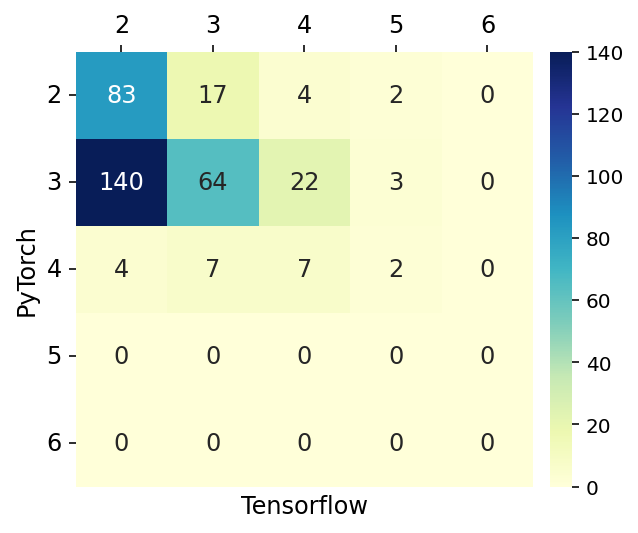

In [81]:
def plot_common_pkg_depth(framework1, framework2):
    data = [[0 for i in range(5)] for j in range(5)]
    pkgs = common_pkgs[f'{framework1}-{framework2}']
    df = pkg_layers[(pkg_layers.package.isin(pkgs)) & (pkg_layers.framework.isin([
        framework1, framework2]))].groupby(['framework', 'package'])['layer'].max()
    for p in pkgs:
        l1, l2 = df.loc[('pytorch', p)], df.loc[('tensorflow', p)]
        data[l1 - 2][l2 - 2] += 1
    x = [2, 3, 4, 5, 6]
    y = [2, 3, 4, 5, 6]
    d = pd.DataFrame(data=data, index=x, columns=y)
    fig, ax = plt.subplots(figsize=(5, 4))
    g = sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={"pad": 0.03}, annot_kws={"size": 12})
    g.set_xlabel('Tensorflow', fontsize=12)
    g.set_ylabel('PyTorch', fontsize=12)
    g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12, ha='center')
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)
    g.xaxis.set_ticks_position('top')
    plt.savefig('figures/torch_tf_common_depth.pdf', bbox_inches='tight')

plot_common_pkg_depth('tensorflow', 'pytorch')

/home/kgao/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

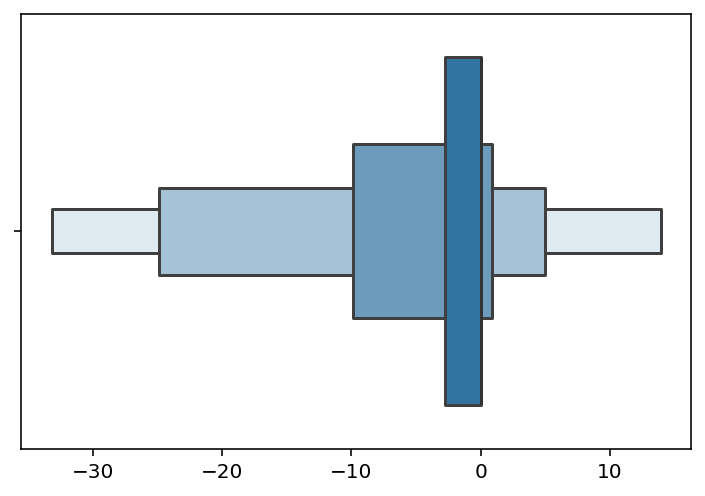

In [120]:
sns.boxenplot(distance_values, showfliers=False)

In [131]:
def sample_packages():
    samples = pd.DataFrame()
    samples = samples.append([pd.concat([pkg_layers[(pkg_layers['framework'] == 'pytorch') &
                                                 (pkg_layers['layer'] == i)].sample(frac=0.1),
                                        pkg_layers[(pkg_layers['framework'] == 'tensorflow') &
                                                 (pkg_layers['layer'] == i)].sample(frac=0.1)],
                                      ignore_index=True) for i in [2, 3]], ignore_index=True)
    samples = samples.append([pd.concat([pkg_layers[(pkg_layers['framework'] == 'pytorch') &
                                                 (pkg_layers['layer'] == i)],
                                        pkg_layers[(pkg_layers['framework'] == 'tensorflow') &
                                                 (pkg_layers['layer'] == i)]],
                                      ignore_index=True) for i in [4, 5, 6]], ignore_index=True)
    samples = samples.append(pkg_layers[(pkg_layers['framework'].isin(['mxnet', 'paddlepaddle', 'mindspore']))
                                          & (pkg_layers['layer'] > 1)])
    samples[['package', 'layer', 'framework']].to_excel('data/samples.xlsx', index=False)
    return samples

In [159]:
samples = sample_packages()
print(samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int))

framework  mindspore  mxnet  paddlepaddle  pytorch  tensorflow
layer                                                         
2                  3     62            34      290         234
3                  0     18             6      190          71
4                  0      1             0      161          89
5                  0      0             0       13          11
6                  0      0             0        1           1


In [165]:
def check_old_samples():
    df = pd.read_excel('data/labelled_samples.xlsx')[['name', 'layer', 'framework', 'DR/NDR', 
                                                      'Category', 'Subcategory', 'Comment']]
    df.rename(columns={"name": "package"}, inplace=True)
    new_samples = pd.DataFrame()
    for f in frameworks:
        for i in range(2, 7):
            p1 = set(df[(df.framework == f) & (df.layer == i)]['package'])
            all_df = pkg_layers[(pkg_layers.framework == f) & (pkg_layers.layer == i)][['package', 'layer', 'framework']]
            p2 = set(all_df['package'])
            df = df[~(df['package'].isin(list(p1 -p2)) & (df['layer'] == i))]
            sample_df = df[(df.framework == f) & (df.layer == i)]
            p1 = set(sample_df['package'])
            
            if (f in ['tensorflow', 'pytorch']) and (i in [2, 3]):
                left = round(len(p2) * 0.1) - len(p1)
            else:
                left = len(p2) - len(p1)
            if left <= 0:
                new_samples = new_samples.append(sample_df.head(len(p1)+left))
            if left > 0:
                new_samples = new_samples.append([sample_df, all_df.sample(left)])
    new_samples.to_csv('data/samples.csv', index=False)
    return new_samples
new_samples = check_old_samples()
# new_samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int)
# print(new_samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int))
# for p in frameworks:
#     print(f'The number of sampled unique packages in {p} SC: {len(new_samples[new_samples.framework==p]["package"].unique())}')

In [170]:
pkg_layers[(pkg_layers.dependent_number > 0)].groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int)

framework,mindspore,mxnet,paddlepaddle,pytorch,tensorflow
layer,,,,,
1,1,7,2,1,3
2,0,8,2,380,245
3,0,1,0,243,111
4,0,0,0,24,21
5,0,0,0,3,4


In [171]:
pkg_layers[pkg_layers.package == 'speechbrain']

,package,layer,framework,dependent_number
3707,speechbrain,2,pytorch,2
3708,speechbrain,3,pytorch,2
